In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient


import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
client = MongoClient()
db_nba= client.nba
collection = db_nba.player_stats
df_nba = pd.DataFrame(list(collection.find()))

Let's take a high-level look at our dataframe.

In [3]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5561 entries, 0 to 5560
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                5561 non-null   object 
 1   Player_ID          5561 non-null   int64  
 2   GROUP_SET          5561 non-null   object 
 3   GROUP_VALUE        5561 non-null   object 
 4   TEAM_ID            5561 non-null   int64  
 5   TEAM_ABBREVIATION  5561 non-null   object 
 6   MAX_GAME_DATE      5561 non-null   object 
 7   GP                 5561 non-null   int64  
 8   W                  5561 non-null   int64  
 9   L                  5561 non-null   int64  
 10  W_PCT              5561 non-null   float64
 11  MIN                5561 non-null   float64
 12  FGM                5561 non-null   int64  
 13  FGA                5561 non-null   int64  
 14  FG_PCT             5561 non-null   float64
 15  FG3M               5561 non-null   int64  
 16  FG3A               5561 

In [21]:
df_nba.loc[0]

_id                  5eb946a2b9f6e704e49edfd7
Player_ID                                   3
GROUP_SET                             By Year
GROUP_VALUE                           2002-03
TEAM_ID                            1610612738
TEAM_ABBREVIATION                         BOS
MAX_GAME_DATE             2003-04-16T00:00:00
GP                                         41
W                                          21
L                                          20
W_PCT                                   0.512
MIN                                   489.728
FGM                                        27
FGA                                        70
FG_PCT                                  0.386
FG3M                                        0
FG3A                                        3
FG3_PCT                                     0
FTM                                        18
FTA                                        23
FT_PCT                                  0.783
OREB                              

In taking a quick look, we can get rid of the '_id' and 'GROUP_SET' columns. 'GROUP_VALUE' should be renamed to 'season' as well. Lastly, for indexing ease, let's lower case all column names. 



In [22]:
df_nba.drop(columns = ['_id','GROUP_SET'], inplace = True)

In [24]:
df_nba.rename(columns={'GROUP_VALUE':'season'}, inplace = True)

In [28]:
d_lower = dict()
for i in df_nba.columns:
    d_lower[i] = i.lower()

df_nba.rename(columns=d_lower, inplace = True)
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'max_game_date',
       'gp', 'w', 'l', 'w_pct', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a',
       'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov',
       'stl', 'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus',
       'nba_fantasy_pts', 'dd2', 'td3', 'cfid', 'cfparams'],
      dtype='object')

# We first want to investigate the predictivity of regular season wins and playoff berths based on a team roster's individual efficiency ratings from the prior year. 

There are a handful of efficiency metrics that are worth invesitgating here:

Martin Manley's Efficiency ('EFF'): ((Points + Rebounds + Assists + Steals + Blocks) - (Missed Field Goals + Missed Free Throws + Turnovers))/ Games Played

European Performance Index Rating ('PIR'): ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed))/ Games Played

Note: We will not be considering John Hollinger's Player Efficiency Rating ('PER'): It is the most frequently used alternative, however PER is derived by a very complex calculation designed to compensate for different teams' varying style of play, among other factors, and PER scores do not differ markedly from EFF scores.

This study is more so interested in an individual player's EFF being predictive of team success, regardless of coaching and playing styles. Furthermore, looking at these raw statistics will help inform to what extent a coach should seek to opitimize all individual player efficiencies, or spend a majority of their time tending to star players, or perhaps optimizing other metrics via playing style.

# Let's calculate EFF and PIR's for each player on a per season basis. Then we'll aggregate team rosters on a yearly basis, to eventually offset one season's stats to be fit to the following season's results.

In [29]:
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'max_game_date',
       'gp', 'w', 'l', 'w_pct', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a',
       'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov',
       'stl', 'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus',
       'nba_fantasy_pts', 'dd2', 'td3', 'cfid', 'cfparams'],
      dtype='object')

In [30]:
"""EFF = ((Points + Rebounds + Assists + Steals + Blocks) - Missed Field Goals - Missed Free Throws - Turnovers))/ Games Played"""

df_nba['eff'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov']) / df_nba['gp']


"""PIR = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - Missed Field Goals - Missed Free Throws - Turnovers - Shots Rejected - Fouls Committed))/ Games Played"""
df_nba['pir'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']+df_nba['pfd']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov'] \
                 - df_nba['blka'] \
                 - df_nba['pf']) / df_nba['gp']

Below are the results of our EFF and PIR calculations.

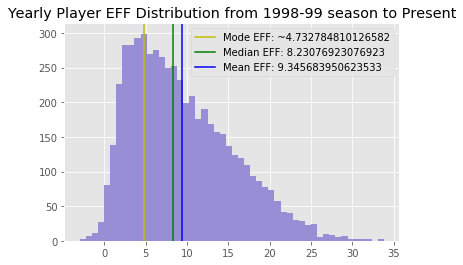

In [59]:
#Calculate all EFF averages and plot histogram to inform distribution

mean_eff = np.mean(df_nba['eff'])
median_eff = np.median(df_nba['eff'])

fig, ax = plt. subplots()

ax.hist(df_nba['eff'], bins = 50)
ax.set_title('Yearly Player EFF Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['eff'], bins = 50)[0],ax.hist(df_nba['eff'], bins = 50)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_eff = np.mean([upper,lower])

ax.axvline(mode_eff, color = 'y', label = f'Mode EFF: ~{mode_eff}')
ax.axvline(median_eff, color = 'g', label = f'Median EFF: {median_eff}')
ax.axvline(mean_eff, color = 'b', label = f'Mean EFF: {mean_eff}')


ax.legend()


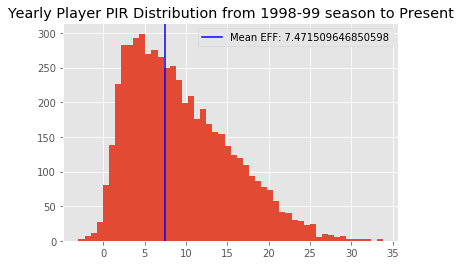

In [49]:
#Calculate all PIR averages and plot histogram to inform distribution

mean_pir = np.mean(df_nba['pir'])
median_pir = np.median(df_nba['pir'])

fig, ax = plt. subplots()

ax.hist(df_nba['pir'], bins = 50)
ax.set_title('Yearly Player PIR Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['pir'], bins = 50)[0],ax.hist(df_nba['eff'], bins = 50)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_eff = np.mean([upper,lower])

ax.axvline(mode_eff, color = 'y', label = f'Mode EFF: ~{mode_eff}')
ax.axvline(median_eff, color = 'g', label = f'Median EFF: {median_eff}')
ax.axvline(mean_eff, color = 'b', label = f'Mean EFF: {mean_eff}')


ax.legend()
